In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re
import random
import csv

/home/ziyi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Network Parameters
num_input = 6
timesteps = 50 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [3]:
def read_sensor(filename):
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile)
        dataset = [row[17:23] for row in reader]
        #data_x
        return np.array(dataset)
    
def read_xml(filename, length):
    f = open(filename)
    cts = f.read()
    f.close()

    p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
    all_foot = p_foot.findall(cts)

    p_time = re.compile(r'<Time>(.*?)</Time>')
    all_time = p_time.findall(cts)

    strike_times = []
    #L-1 R-0
    strike_times.append([0.0, 0.5])
    for i in range(len(all_foot)):
        if(all_foot[i]=='L'):
            strike_times.append([float(all_time[i]), 1])
        else:
            strike_times.append([float(all_time[i]), 0])
    strike_times[-1][1] = 0.5
    strike_times.append([length/25.0, 0.5])

    window_y = []
    strike_index=0
    for i in range(length):
        if(i/25.0 >= strike_times[strike_index+1][0]):
            strike_index += 1
        window_y.append([strike_times[strike_index][1]])

    p_info = re.compile(r'<StartTime>(.*?)</StartTime>\n\t<EndTime>(.*?)</EndTime>\n\t<NSteps>(.*?)</NSteps>\n\t<Direction>(.*?)</Direction>')
    all_info = p_info.findall(cts)#start_time, end_time, step_num, direction=turn

    for i in range(len(all_info)):
        if(all_info[i][3][:4]=='Turn'):
#             print(all_info[i])
            start_time = int(float(all_info[i][0])*25)
            end_time = int(float(all_info[i][1])*25)
#             print('start and end time : ', all_info[i][0], all_info[i][1])
            for t in range(start_time-1, end_time):
                window_y[t] = [0.5]

    p_feature = re.compile(r'<Feature>\n\t\t\t<StartTime>(.*?)</StartTime>\n\t\t\t<EndTime>(.*?)</EndTime>')
    all_feature = p_feature.findall(cts)#start_time, end_time, step_num, direction=turn
    
#     print(filename, length)
    for i in range(len(all_feature)):
        start_time = int(float(all_feature[i][0])*25)
        end_time = int(float(all_feature[i][1])*25)
#         print(start_time-1, end_time)
        if(end_time<=length):
            for t in range(start_time-1, end_time):
                window_y[t] = [0.5]
            
#     print(len(window_y))  
    return window_y

def add_data(path, person, phone_location, assistant):
    data_x = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(path)+'_ID'+str(person)+'_'+phone_location+'_'+assistant+'.csv')
    data_y = read_xml('weallwalk/xml/T'+str(path)+'_ID'+str(person)+'_'+assistant+'.xml', len(data_x))
    
    split_x, split_x_part = [], []
    split_y, split_y_part = [], []
    for i in range(len(data_y)):
        if(data_y[i][0]!=0.5):
            split_y_part.append(data_y[i])
            split_x_part.append(data_x[i])
        else:
            if(len(split_y_part)>0):
                split_y.append(split_y_part)
                split_x.append(split_x_part)
                split_y_part = []
                split_x_part = []
    
    data_x_seq, data_y_seq = [], []
    for i in range(len(split_x)):
        data_x_part, data_y_part = [], []
        for j in range(len(split_x[i])-timesteps):
            x = split_x[i][j:j+timesteps]
            y = split_y[i][j:j+timesteps]
            data_x_part.append(x)
            data_y_part.append(y)
        if(len(data_x_part)>0):
            data_x_seq.append(data_x_part)
            data_y_seq.append(data_y_part)
    
    return data_x_seq, data_y_seq

In [4]:
all_train_data_list = []
#[4, 6, '2R', 'WC']
for i in range(1,6): #1,2,3,5,6,  7,8,  9, 10
    all_train_data_list.append([i, 1, '1L', 'WC'])
    all_train_data_list.append([i, 1, '2R', 'WC'])
    all_train_data_list.append([i, 2, '1L', 'WC'])
    all_train_data_list.append([i, 2, '2R', 'WC'])
    
    all_train_data_list.append([i, 3, '1L', 'WC'])
    all_train_data_list.append([i, 3, '2R', 'WC'])
    all_train_data_list.append([i, 5, '1L', 'WC'])
    all_train_data_list.append([i, 5, '2R', 'WC'])
    
    
    all_train_data_list.append([i, 6, '1L', 'WC'])
    all_train_data_list.append([i, 6, '2R', 'WC'])
    all_train_data_list.append([i, 7, '1L', 'WC'])
    all_train_data_list.append([i, 7, '2R', 'WC'])
#     all_data_list.append([i, 8, '1L', 'WC'])
#     all_data_list.append([i, 8, '2R', 'WC'])   

all_train_data_list.append([7, 9, '1L', 'WC'])
all_train_data_list.append([8, 9, '1L', 'WC'])
all_train_data_list.append([9, 10, '1L', 'WC'])
all_train_data_list.append([10, 10, '1L', 'WC'])                          

all_train_data_list.append([7, 9, '2R', 'WC'])
all_train_data_list.append([8, 9, '2R', 'WC'])
all_train_data_list.append([9, 10, '2R', 'WC'])
all_train_data_list.append([10, 10, '2R', 'WC'])

all_train_data_list.remove([4, 6, '2R', 'WC'])
print(all_train_data_list)

[[1, 1, '1L', 'WC'], [1, 1, '2R', 'WC'], [1, 2, '1L', 'WC'], [1, 2, '2R', 'WC'], [1, 3, '1L', 'WC'], [1, 3, '2R', 'WC'], [1, 5, '1L', 'WC'], [1, 5, '2R', 'WC'], [1, 6, '1L', 'WC'], [1, 6, '2R', 'WC'], [1, 7, '1L', 'WC'], [1, 7, '2R', 'WC'], [2, 1, '1L', 'WC'], [2, 1, '2R', 'WC'], [2, 2, '1L', 'WC'], [2, 2, '2R', 'WC'], [2, 3, '1L', 'WC'], [2, 3, '2R', 'WC'], [2, 5, '1L', 'WC'], [2, 5, '2R', 'WC'], [2, 6, '1L', 'WC'], [2, 6, '2R', 'WC'], [2, 7, '1L', 'WC'], [2, 7, '2R', 'WC'], [3, 1, '1L', 'WC'], [3, 1, '2R', 'WC'], [3, 2, '1L', 'WC'], [3, 2, '2R', 'WC'], [3, 3, '1L', 'WC'], [3, 3, '2R', 'WC'], [3, 5, '1L', 'WC'], [3, 5, '2R', 'WC'], [3, 6, '1L', 'WC'], [3, 6, '2R', 'WC'], [3, 7, '1L', 'WC'], [3, 7, '2R', 'WC'], [4, 1, '1L', 'WC'], [4, 1, '2R', 'WC'], [4, 2, '1L', 'WC'], [4, 2, '2R', 'WC'], [4, 3, '1L', 'WC'], [4, 3, '2R', 'WC'], [4, 5, '1L', 'WC'], [4, 5, '2R', 'WC'], [4, 6, '1L', 'WC'], [4, 7, '1L', 'WC'], [4, 7, '2R', 'WC'], [5, 1, '1L', 'WC'], [5, 1, '2R', 'WC'], [5, 2, '1L', 'WC'],

In [5]:
step_train_data_list = []
step_valid_data_list = []
for i in range(1, 8):
    if(i==4):
        continue
    step_train_data_list_part = [j for j in all_train_data_list if j[1]!=i]
    step_valid_data_list_part = [j for j in all_train_data_list if j[1]==i]
    print(len(step_train_data_list_part))
    print(step_train_data_list_part)
    print('-----')
    print(len(step_valid_data_list_part))
    print(step_valid_data_list_part)
    print('=====')
    step_train_data_list.append(step_train_data_list_part)
    step_valid_data_list.append(step_valid_data_list_part)
    
    

57
[[1, 2, '1L', 'WC'], [1, 2, '2R', 'WC'], [1, 3, '1L', 'WC'], [1, 3, '2R', 'WC'], [1, 5, '1L', 'WC'], [1, 5, '2R', 'WC'], [1, 6, '1L', 'WC'], [1, 6, '2R', 'WC'], [1, 7, '1L', 'WC'], [1, 7, '2R', 'WC'], [2, 2, '1L', 'WC'], [2, 2, '2R', 'WC'], [2, 3, '1L', 'WC'], [2, 3, '2R', 'WC'], [2, 5, '1L', 'WC'], [2, 5, '2R', 'WC'], [2, 6, '1L', 'WC'], [2, 6, '2R', 'WC'], [2, 7, '1L', 'WC'], [2, 7, '2R', 'WC'], [3, 2, '1L', 'WC'], [3, 2, '2R', 'WC'], [3, 3, '1L', 'WC'], [3, 3, '2R', 'WC'], [3, 5, '1L', 'WC'], [3, 5, '2R', 'WC'], [3, 6, '1L', 'WC'], [3, 6, '2R', 'WC'], [3, 7, '1L', 'WC'], [3, 7, '2R', 'WC'], [4, 2, '1L', 'WC'], [4, 2, '2R', 'WC'], [4, 3, '1L', 'WC'], [4, 3, '2R', 'WC'], [4, 5, '1L', 'WC'], [4, 5, '2R', 'WC'], [4, 6, '1L', 'WC'], [4, 7, '1L', 'WC'], [4, 7, '2R', 'WC'], [5, 2, '1L', 'WC'], [5, 2, '2R', 'WC'], [5, 3, '1L', 'WC'], [5, 3, '2R', 'WC'], [5, 5, '1L', 'WC'], [5, 5, '2R', 'WC'], [5, 6, '1L', 'WC'], [5, 6, '2R', 'WC'], [5, 7, '1L', 'WC'], [5, 7, '2R', 'WC'], [7, 9, '1L', 'WC

In [7]:
batch_size = 256
train_x_list, train_y_list = [], []
print(batch_size)

for step_train_data in step_train_data_list:
    data_x, data_y = [], []
    
    for i in step_train_data:
        data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
        for dx in data_x_segement:
            data_x.extend(dx)
        for dy in data_y_segement:
            data_y.extend(dy)
    
    print(len(data_x))
#     print(len(data_y))
    
    order = list(range(0,len(data_x),1))
    random.shuffle(order)

    train_x = [data_x[i] for i in order]
#     train_x.extend([i for i in train_x[:batch_size]])
    train_x.extend([train_x[i] for i in range(0, batch_size)])
    train_y = [data_y[i] for i in order]
#     train_y.extend([i for i in train_y[:batch_size]])
    train_y.extend([train_y[i] for i in range(0, batch_size)])

    print(len(train_x))
    
    train_x_list.append(train_x)
    train_y_list.append(train_y)

256
159964
160220
160982
161238
163716
163972
164766
165022
170706
170962
165084
165340


In [8]:
valid_x_list, valid_y_list = [], []

for step_valid_data in step_valid_data_list:
    valid_x, valid_y=[], []
    for i in step_valid_data:
        data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
        valid_x.extend(data_x_segement)
        valid_y.extend(data_y_segement)
    
    print(len(valid_x))
#     print(len(valid_y))
    
    valid_x_list.append(valid_x)
    valid_y_list.append(valid_y)

72
64
62
66
56
52


In [9]:
step_test_list = []
for i in range(1,7):
    step_test_list.append([i, 8, '1L', 'WC'])
    step_test_list.append([i, 8, '2R', 'WC'])  
      
print(step_test_list)

[[1, 8, '1L', 'WC'], [1, 8, '2R', 'WC'], [2, 8, '1L', 'WC'], [2, 8, '2R', 'WC'], [3, 8, '1L', 'WC'], [3, 8, '2R', 'WC'], [4, 8, '1L', 'WC'], [4, 8, '2R', 'WC'], [5, 8, '1L', 'WC'], [5, 8, '2R', 'WC'], [6, 8, '1L', 'WC'], [6, 8, '2R', 'WC']]


In [10]:
test_x, test_y=[], []
for i in step_test_list:
    data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
    test_x.extend(data_x_segement)
    test_y.extend(data_y_segement)
    
print(len(test_x))
print(len(test_y))

print([len(i) for i in test_y])

64
64
[113, 249, 940, 93, 113, 249, 940, 93, 100, 1370, 160, 76, 100, 1370, 160, 76, 1737, 374, 1737, 374, 411, 1647, 300, 1266, 380, 919, 159, 862, 411, 1647, 300, 1266, 380, 919, 159, 862, 141, 392, 841, 324, 204, 211, 352, 35, 517, 382, 261, 141, 392, 841, 324, 204, 211, 352, 35, 517, 382, 261, 47, 828, 1405, 47, 828, 1405]


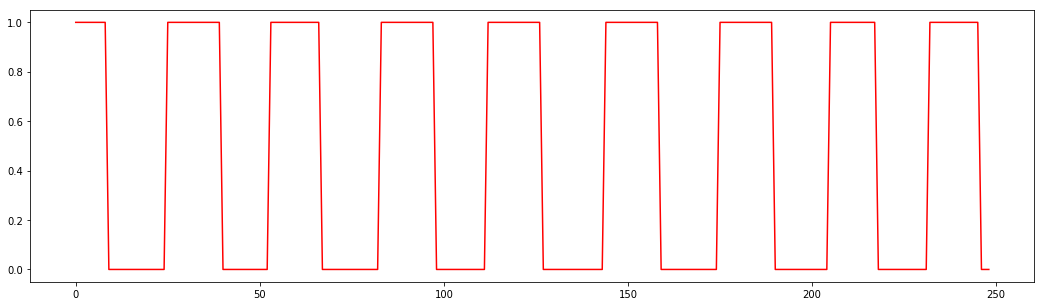

In [11]:
plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in test_y[1]], 'r')
plt.show()

In [12]:
NUM_LAYERS=2

def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden)#, forget_bias=1.0)
    cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=0.5)
    return cell

graph = tf.Graph()
with graph.as_default(), tf.device('/gpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, timesteps, num_output])
    
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
    }
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        outputs = tf.transpose(outputs, [1,0,2])

#         return tf.matmul(outputs[-2], weights['out']) + biases['out']
        ret = []
#         print(outputs.shape)
        for i in range(0, timesteps):
            ret.append(tf.matmul(outputs[i], weights['out']) + biases['out'])
            
        return ret

#         return np.array(ret)
    
    logits = RNN(X, weights, biases)
    logits = tf.transpose(logits, [1,0,2])
#     print(len(logits))
    print(logits.shape)
    print(logits[0].shape)
    mean_train = tf.reduce_mean(X)
    
    
    loss = tf.reduce_mean(tf.squared_difference(logits, Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
    
    saver = tf.train.Saver()

(?, 50, 1)
(50, 1)


In [13]:
def cal_accuarcy(y, _y):
#     print(len(y))
#     print(len(y[0]))
#     print(len(y[0][0]))
#     print(y[0][0])
    count = 0
    total = 0
    for i in range(len(y[0])):
        total += 1
        if(y[0][i][0] == round(_y[0][i][0])):
            count += 1
    for i in range(1, len(y)):
        total += 1
        if(y[i][-1][0] == round(_y[i][-1][0])):
            count += 1;
    return(count*1.0/total)
#     print("train accuarcy : ", count/len(y))

In [14]:
print(len(train_x_list))
print(len(train_x_list[0]))
print(len(train_x_list[0][0]))
print(len(train_x_list[0][0][0]))
# print(train_x_list[0][0].shape)
batch_start = 0

6
160220
50
6


In [97]:
training_steps = 1001
valid_loss_list, valid_logits_list = [], []
test_loss_list, test_logits_list = [], []

for i in range(1, 2):
    batch_start=0
    print("cross validation ", i)
#     batch_start = 0
    train_x = train_x_list[i]
    train_y = train_y_list[i]
    train_length = len(train_x_list[i])-256
    valid_x = valid_x_list[i]
    valid_y = valid_y_list[i]
    config = tf.ConfigProto(allow_soft_placement=True)
    with tf.Session(graph=graph, config=config) as session:
        saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
#         saver.restore(session, "lstm_check/my-model-gpu-error-metric-dropout2-wc-10fold-1.ckpt-6000")
#         tf.global_variables_initializer().run()
        print('Initialized')
        for step in range(training_steps):      
            feed_dict = {X: train_x[batch_start:batch_start+batch_size], Y: train_y[batch_start:batch_start+batch_size]}
            _, l, predictions, m = session.run([optimizer, loss, logits, mean_train], feed_dict = feed_dict)
            if (step % 200 == 0):
                train_accuarcy = cal_accuarcy(train_y[batch_start:batch_start+batch_size], predictions)
                print('Loss at step %d: %f, train accuarcy : %f' % (step, l, train_accuarcy))
                #train accuarcy
            if (step % 1000 == 0):
                saver.save(session, 'lstm_check/my-model-gpu-error-metric-dropout2-wc-10fold-'+str(i)+'.ckpt', global_step=step+4000)
            batch_start += batch_size
            if(batch_start>=train_length):
                batch_start -=train_length
        valid_loss, valid_logits = [], []
        for j in range(len(valid_x)):
            valid_loss_part, valid_logits_part = session.run([loss,logits], feed_dict={X: valid_x[j], Y: valid_y[j]})
            valid_loss.append(valid_loss_part)
            valid_logits.append(valid_logits_part)

        valid_loss_list.append(valid_loss)
        valid_logits_list.append(valid_logits)

        test_loss, test_logits = [], []
        for j in range(len(test_x)):
            test_loss_part, test_logits_part = session.run([loss,logits], feed_dict={X: test_x[j], Y: test_y[j]})
            test_loss.append(test_loss_part)
            test_logits.append(test_logits_part)

        test_loss_list.append(test_loss)
        test_logits_list.append(test_logits)

cross validation  1
INFO:tensorflow:Restoring parameters from lstm_check/my-model-gpu-error-metric-dropout2-wc-10fold-1.ckpt-4000
Initialized
Loss at step 0: 0.076400, train accuarcy : 0.934426
Loss at step 200: 0.067454, train accuarcy : 0.927869
Loss at step 400: 0.070662, train accuarcy : 0.927869
Loss at step 600: 0.071571, train accuarcy : 0.940984
Loss at step 800: 0.068471, train accuarcy : 0.901639
Loss at step 1000: 0.069057, train accuarcy : 0.901639


In [98]:
print("test loss : ", test_loss)

test loss :  [0.40247214, 0.33778018, 0.35660747, 0.3300463, 0.23266226, 0.32320023, 0.23123546, 0.27043951, 0.38035589, 0.39892742, 0.36656404, 0.41828689, 0.24934553, 0.25080076, 0.2086983, 0.28119698, 0.42841667, 0.40974757, 0.27223572, 0.31180972, 0.42738318, 0.40798455, 0.34968367, 0.42926681, 0.4514378, 0.45140931, 0.44158301, 0.47750181, 0.2604869, 0.24906546, 0.35775831, 0.18019076, 0.33781612, 0.16686578, 0.24245867, 0.18545859, 0.26288974, 0.27696967, 0.28656432, 0.29319102, 0.30713338, 0.25394297, 0.28747702, 0.25149789, 0.29456535, 0.27479365, 0.31427443, 0.34310347, 0.19539568, 0.27604559, 0.22474281, 0.26618677, 0.26356506, 0.25028771, 0.19376081, 0.21901003, 0.27293286, 0.2100296, 0.46482283, 0.29738078, 0.27358642, 0.2834802, 0.31623289, 0.23333418]


64
64


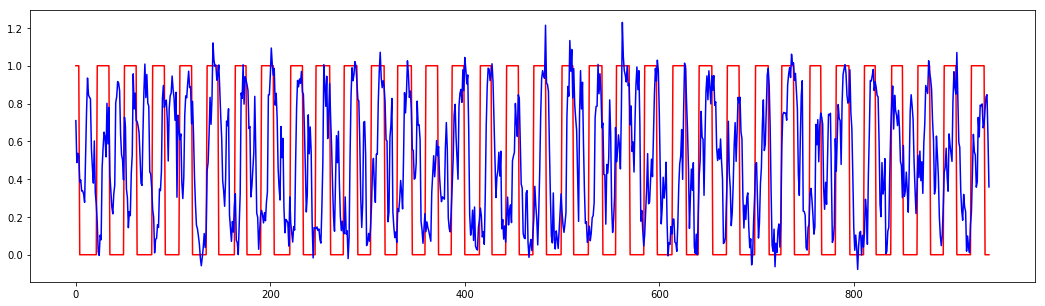

In [99]:
print(len(test_y))
print(len(test_logits_list[0]))

index = 0
index1= 6

test_logits = test_logits_list[index]


plt.figure(figsize=(18, 5))
start=0
end=2000
plt.plot([i[-1][0] for i in test_y[index1][start:end]], 'r')
plt.plot([i[-1][0] for i in test_logits[index1][start:end]], 'b')
plt.show()

In [100]:
print(len(test_logits))
print(len(test_logits[0]))
print(len(test_logits[0][0]))  

test_y_seq_list, test_logits_bin_list = [], []

for t in test_logits:  
    t_all = [i for i in t[0]]
    t_all.extend([i[-1] for i in t[1:]])
#     print(len(t_all)-len(t))
    
    test_logits_part = [[round(i[0])] for i in t_all]
    for i in range(1, len(test_logits_part)-1):
        if(test_logits_part[i-1][0]!=test_logits_part[i][0] and test_logits_part[i-1][0]==test_logits_part[i+1][0]):
            test_logits_part[i][0]=test_logits_part[i-1][0]    
    test_logits_bin_list.append(test_logits_part)
    
for t in test_y:  
    t_all = [i for i in t[0]]
    t_all.extend([i[-1] for i in t[1:]])
    test_y_seq_list.append(t_all)

# print(test_y_seq_list)
    
count = 0
total = 0
for i in range(0, len(test_y_seq_list)):
    total += len(test_y_seq_list[i])
    for j in range(0, len(test_y_seq_list[i])):
        if(test_y_seq_list[i][j][0] == test_logits_bin_list[i][j][0]):
            count += 1

print(count)
print(total)
print("test accuarcy : ", count*1.0/total)

64
113
50
21037
37328
test accuarcy :  0.563571581654522


In [101]:
step_time_actual, step_time_predict= [], []
step_time_actual_gap = []

#test_y_seq_list, test_logits_bin_list
for i in range(0, len(test_y_seq_list)):
    step_time_actual_part, step_time_predict_part= [], []
    for j in range(1, len(test_y_seq_list[i])):
        if(abs(test_y_seq_list[i][j][0]-test_y_seq_list[i][j-1][0])>0.5):
            step_time_actual_part.append(j)
    #     if(abs(test_logits[i][0]-test_logits[i-1][0])>0.5):
        if(abs(test_logits_bin_list[i][j][0]-test_logits_bin_list[i][j-1][0])>0.5):
            step_time_predict_part.append(j)
    step_time_actual.append(step_time_actual_part)
    step_time_predict.append(step_time_predict_part)
    
    step_time_actual_gap_part = []
    step_time_actual_gap_part.append(0)
#     step_time_actual_gap_part.append(step_time_actual_part[0]/2.0)
    for i in range(1, len(step_time_actual_part)):
        step_time_actual_gap_part.append((step_time_actual_part[i-1]+step_time_actual_part[i])/2.0)
    step_time_actual_gap_part.append(step_time_actual_part[-1]*2)
    step_time_actual_gap.append(step_time_actual_gap_part)

print('Step number for each segement')
print([len(i) for i in step_time_actual])   
print([len(i) for i in step_time_predict])

print('======')
iii = 13
print(step_time_actual[iii])
print(step_time_actual_gap[iii])
print(step_time_predict[iii])

Step number for each segement
[11, 20, 70, 9, 11, 20, 70, 9, 10, 95, 14, 7, 10, 95, 14, 7, 112, 28, 112, 28, 31, 104, 19, 93, 19, 68, 13, 64, 31, 104, 19, 93, 19, 68, 13, 64, 12, 33, 55, 26, 16, 19, 27, 6, 40, 29, 22, 12, 33, 55, 26, 16, 19, 27, 6, 40, 29, 22, 6, 57, 96, 6, 57, 96]
[11, 23, 71, 9, 13, 25, 110, 13, 11, 104, 13, 10, 19, 152, 22, 16, 125, 30, 196, 54, 33, 117, 19, 83, 24, 66, 14, 71, 53, 168, 37, 146, 49, 103, 27, 98, 19, 50, 97, 42, 25, 23, 35, 8, 58, 39, 37, 13, 45, 79, 44, 34, 22, 46, 12, 52, 48, 30, 15, 74, 131, 11, 93, 144]
[6, 24, 35, 52, 70, 166, 179, 196, 207, 225, 236, 253, 264, 281, 293, 309, 320, 337, 348, 365, 377, 395, 404, 421, 432, 448, 460, 477, 487, 505, 516, 532, 545, 562, 573, 590, 601, 619, 629, 646, 657, 674, 685, 702, 713, 730, 742, 759, 769, 786, 797, 814, 827, 842, 853, 870, 881, 898, 909, 925, 936, 953, 965, 982, 991, 1011, 1024, 1042, 1055, 1072, 1081, 1099, 1110, 1127, 1137, 1155, 1166, 1183, 1194, 1212, 1222, 1239, 1250, 1267, 1279, 1294, 1305,

In [102]:
total_step_count = sum([len(i) for i in step_time_actual])
metric1_undercount = 0
metric2_undercount = 0
metric3_undercount = 0
metric1_overcount = 0
metric2_overcount = 0
metric3_overcount = 0

metric2_overcount_list = []
metric3_overcount_list = []

print(len(test_x))

for i in range(len(test_x)):
    step_count = len(step_time_actual[i])
    undercount = 0
    overcount = 0

    for j in range(1, step_count):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][j-1] and t<step_time_actual[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += len(gap_count)-1
        if(len(gap_count)<1):
            undercount += 1
    gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][-1]]
    if(len(gap_count)>1):
        overcount += len(gap_count)-1
    if(len(gap_count)<1):
        undercount += 1
    
    metric1_undercount += undercount
    metric1_overcount += overcount
    
    undercount = 0
    overcount = 0
    for j in range(1, len(step_time_actual_gap[i])):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual_gap[i][j-1] and t<step_time_actual_gap[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += (len(gap_count)-1)
        if(len(gap_count)<1):
            undercount += 1    
    
    metric2_undercount += undercount
    metric2_overcount += overcount  
    metric2_overcount_list.append(overcount)
    
#     print(undercount, overcount)
#     print('undercount : ', undercount*1.0/step_count)
#     print('overcount : ', overcount*1.0/step_count)
    diff = len(step_time_predict[i])-len(step_time_actual[i])
#     if(diff==0):
#         print("segement correct!")

    if(diff<0):
#         print('segement undercount : ', 1-len(step_time_predict[i])*1.0/len(step_time_actual[i]))
        metric3_undercount -= diff
        metric3_overcount_list.append(0)
#     if(diff>=0):
    else:
#         print('segement overcount : ', 1-len(step_time_actual[i])*1.0/len(step_time_predict[i]))
        metric3_overcount += diff
        metric3_overcount_list.append(diff)

print(len(metric2_overcount_list))
print(sum(metric2_overcount_list))
print(metric2_overcount_list)
print(len(metric3_overcount_list))
print(sum(metric3_overcount_list))
print(metric3_overcount_list)
        
print('error : ')
print("total undercount metric 1:\t", metric1_undercount*1.0/total_step_count)
print("total overcount metric 1:\t", metric1_overcount*1.0/total_step_count)
print("total undercount metric 2:\t", metric2_undercount*1.0/total_step_count)
print("total overcount metric 2:\t", metric2_overcount*1.0/total_step_count)
print("total undercount metric 3:\t", metric3_undercount*1.0/total_step_count)
print("total overcount metric 3:\t", metric3_overcount*1.0/total_step_count)

64
64
1398
[2, 5, 26, 1, 5, 10, 47, 7, 3, 41, 2, 5, 9, 64, 8, 10, 50, 12, 95, 27, 9, 51, 3, 33, 8, 23, 4, 15, 24, 73, 19, 62, 30, 38, 15, 38, 7, 18, 44, 16, 9, 7, 14, 3, 19, 11, 17, 6, 17, 32, 19, 19, 10, 20, 6, 17, 21, 13, 9, 21, 38, 6, 45, 60]
64
1012
[0, 3, 1, 0, 2, 5, 40, 4, 1, 9, 0, 3, 9, 57, 8, 9, 13, 2, 84, 26, 2, 13, 0, 0, 5, 0, 1, 7, 22, 64, 18, 53, 30, 35, 14, 34, 7, 17, 42, 16, 9, 4, 8, 2, 18, 10, 15, 1, 12, 24, 18, 18, 3, 19, 6, 12, 19, 8, 9, 17, 35, 5, 36, 48]
error : 
total undercount metric 1:	 0.10316815597075549
total overcount metric 1:	 0.47969130787977254
total undercount metric 2:	 0.1620633631194151
total overcount metric 2:	 0.5678310316815597
total undercount metric 3:	 0.005280259951259139
total overcount metric 3:	 0.4110479285134037


In [232]:
201 error : 
total undercount metric 1:	 0.03899268887083672
total overcount metric 1:	 0.07636068237205523
total undercount metric 2:	 0.08813972380178717
total overcount metric 2:	 0.14947197400487408
total undercount metric 3:	 0.002843216896831844
total overcount metric 3:	 0.06417546709991877
    
1001   error : 
total undercount metric 1:	 0.14825345247766045
total overcount metric 1:	 0.2802599512591389
total undercount metric 2:	 0.05117790414297319
total overcount metric 2:	 0.210804224207961
total undercount metric 3:	 0.0016246953696181965
total overcount metric 3:	 0.16125101543460602
    
    error : 
total undercount metric 1:	 0.07839155158407798
total overcount metric 1:	 0.21283509341998375
total undercount metric 2:	 0.11291632818846466
total overcount metric 2:	 0.272948822095857
total undercount metric 3:	 0.0016246953696181965
total overcount metric 3:	 0.16165718927701056
    
    error : 
total undercount metric 1:	 0.08651502843216897
total overcount metric 1:	 0.41348497156783104
total undercount metric 2:	 0.12916328188464662
total overcount metric 2:	 0.4813160032493907
total undercount metric 3:	 0.0
total overcount metric 3:	 0.3521527213647441
    
    error : 
total undercount metric 1:	 0.12916328188464662
total overcount metric 1:	 0.45572705117790413
total undercount metric 2:	 0.15597075548334688
total overcount metric 2:	 0.5142160844841592
total undercount metric 3:	 0.004467912266450041
total overcount metric 3:	 0.3627132412672624

SyntaxError: invalid syntax (<ipython-input-232-8282f2f7bc86>, line 1)

# valid

64
64


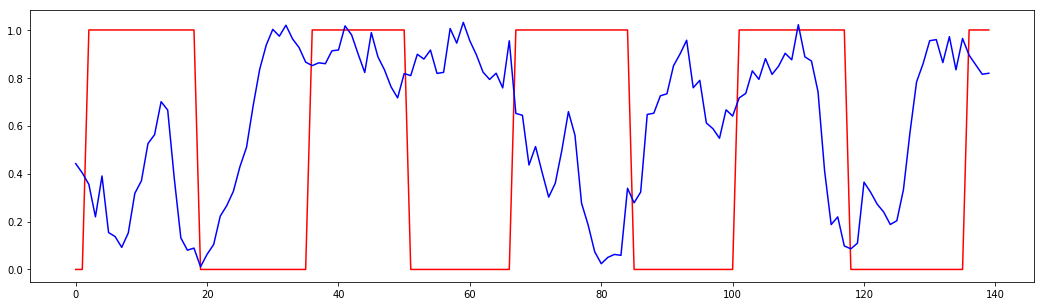

In [89]:
print(len(valid_y))
print(len(valid_logits_list[0]))

index=1

valid_logits = valid_logits_list[0]
valid_y = valid_y_list[index]


plt.figure(figsize=(18, 5))
start=0
end=2000
plt.plot([i[-1][0] for i in valid_y[index1][start:end]], 'r')
plt.plot([i[-1][0] for i in valid_logits[index1][start:end]], 'b')
plt.show()

In [90]:
print(len(test_logits_list), len(test_logits_list[0]), len(test_logits_list[0][0]), len(test_logits_list[0][0][0]))
print(0, len(test_y), len(test_y[0]), len(test_y[0][0]))

1 64 113 50
0 64 113 50


In [91]:
# index=1
print(len(valid_logits_list), len(valid_logits_list[0]), len(valid_logits_list[0][0]), len(valid_logits_list[0][0][0]))
print(len(valid_y_list), len(valid_y_list[index]), len(valid_y_list[index][0]), len(valid_y_list[index][0][0]))

1 64 140 50
6 64 140 50


In [92]:
print(len(valid_logits), len(valid_logits[0]), len(valid_logits[0][0]))


print(len(valid_y))
print(len(valid_y[0]))
print(len(valid_y[0][0]))  

valid_y_seq_list, valid_logits_bin_list = [], []

for t in valid_logits:  
    t_all = [i for i in t[0]]
    t_all.extend([i[-1] for i in t[1:]])
#     print(len(t_all)-len(t))
    
    valid_logits_part = [[round(i[0])] for i in t_all]
    for i in range(1, len(valid_logits_part)-1):
        if(valid_logits_part[i-1][0]!=valid_logits_part[i][0] and valid_logits_part[i-1][0]==valid_logits_part[i+1][0]):
            valid_logits_part[i][0]=valid_logits_part[i-1][0]  
    
    valid_logits_bin_list.append(valid_logits_part)
    
for t in valid_y:  
    t_all = [i for i in t[0]]
    t_all.extend([i[-1] for i in t[1:]])
    valid_y_seq_list.append(t_all)

# print(valid_y_seq_list)
    
count = 0
total = 0
for i in range(0, len(valid_y_seq_list)):
    total += len(valid_y_seq_list[i])
#     print(len(valid_y_seq_list[i]), len(valid_logits_bin_list[i]))
    
    for j in range(0, len(valid_y_seq_list[i])):
        if(valid_y_seq_list[i][j][0] == valid_logits_bin_list[i][j][0]):
            count += 1

print(count)
print(total)
print("valid accuarcy : ", count*1.0/total)

64 140 50
64
140
50
14564
34436
valid accuarcy :  0.42292949239168315


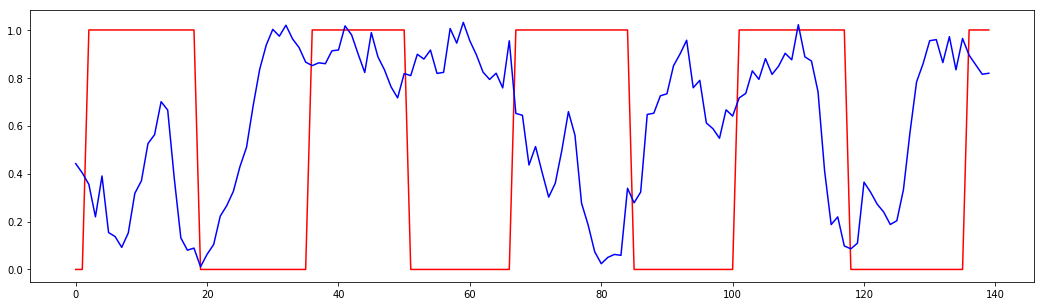

In [93]:


plt.figure(figsize=(18, 5))
plt.plot([i[-1][0] for i in valid_y[index1]], 'r')
plt.plot([i[-1][0] for i in valid_logits[index1]], 'b')
# plt.plot([round(i[-1][0]) for i in test_logits[index]], 'b')
plt.show()

In [94]:
step_time_actual, step_time_predict= [], []
step_time_actual_gap = []

#valid_y_seq_list, valid_logits_bin_list
for i in range(0, len(valid_y_seq_list)):
    step_time_actual_part, step_time_predict_part= [], []
    for j in range(1, len(valid_y_seq_list[i])):
        if(abs(valid_y_seq_list[i][j][0]-valid_y_seq_list[i][j-1][0])>0.5):
            step_time_actual_part.append(j)
    #     if(abs(valid_logits[i][0]-valid_logits[i-1][0])>0.5):
        if(abs(valid_logits_bin_list[i][j][0]-valid_logits_bin_list[i][j-1][0])>0.5):
            step_time_predict_part.append(j)
    step_time_actual.append(step_time_actual_part)
    step_time_predict.append(step_time_predict_part)
    
    step_time_actual_gap_part = []
    step_time_actual_gap_part.append(0)
#     step_time_actual_gap_part.append(step_time_actual_part[0]/2.0)
    for i in range(1, len(step_time_actual_part)):
        step_time_actual_gap_part.append((step_time_actual_part[i-1]+step_time_actual_part[i])/2.0)
    step_time_actual_gap_part.append(step_time_actual_part[-1]*2)
    step_time_actual_gap.append(step_time_actual_gap_part)

print('Step number for each segement')
print([len(i) for i in step_time_actual])   
print([len(i) for i in step_time_predict])

print('======')
iii = 13
print(step_time_actual[iii])
print(step_time_actual_gap[iii])
print(step_time_predict[iii])

Step number for each segement
[11, 15, 2, 40, 34, 12, 11, 15, 2, 40, 34, 12, 10, 95, 14, 5, 10, 95, 14, 5, 99, 32, 99, 32, 12, 3, 10, 74, 22, 14, 97, 16, 75, 13, 66, 12, 3, 10, 74, 22, 14, 97, 16, 75, 13, 66, 7, 38, 7, 52, 22, 3, 31, 26, 99, 7, 38, 7, 52, 22, 3, 31, 26, 99]
[13, 20, 6, 57, 61, 16, 11, 16, 5, 58, 40, 15, 17, 133, 23, 10, 20, 107, 19, 8, 140, 44, 107, 41, 20, 5, 15, 122, 42, 21, 166, 29, 118, 26, 124, 14, 3, 13, 80, 26, 18, 104, 20, 86, 23, 78, 10, 46, 12, 80, 34, 6, 42, 44, 146, 5, 37, 6, 57, 23, 3, 30, 26, 100]
[12, 28, 46, 62, 77, 92, 110, 124, 139, 155, 171, 186, 202, 217, 234, 248, 264, 278, 295, 311, 326, 342, 358, 374, 389, 405, 420, 435, 449, 466, 481, 497, 511, 527, 544, 559, 574, 590, 605, 620, 636, 652, 666, 682, 698, 713, 729, 743, 760, 774, 789, 804, 820, 836, 850, 866, 882, 896, 910, 926, 941, 956, 971, 986, 1003, 1017, 1031, 1046, 1061, 1076, 1092, 1108, 1122, 1137, 1152, 1167, 1184, 1199, 1213, 1229, 1243, 1258, 1274, 1290, 1304, 1320, 1336, 1353, 1369, 1

In [95]:
total_step_count = sum([len(i) for i in step_time_actual])
metric1_undercount = 0
metric2_undercount = 0
metric3_undercount = 0
metric1_overcount = 0
metric2_overcount = 0
metric3_overcount = 0

metric2_overcount_list = []
metric3_overcount_list = []

print(len(valid_x))

for i in range(len(valid_x)):
    step_count = len(step_time_actual[i])
    undercount = 0
    overcount = 0

    for j in range(1, step_count):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][j-1] and t<step_time_actual[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += len(gap_count)-1
        if(len(gap_count)<1):
            undercount += 1
    gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][-1]]
    if(len(gap_count)>1):
        overcount += len(gap_count)-1
    if(len(gap_count)<1):
        undercount += 1
    
    metric1_undercount += undercount
    metric1_overcount += overcount
    
    undercount = 0
    overcount = 0
    for j in range(1, len(step_time_actual_gap[i])):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual_gap[i][j-1] and t<step_time_actual_gap[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += (len(gap_count)-1)
        if(len(gap_count)<1):
            undercount += 1    
    
    metric2_undercount += undercount
    metric2_overcount += overcount  
    metric2_overcount_list.append(overcount)
    
#     print(undercount, overcount)
#     print('undercount : ', undercount*1.0/step_count)
#     print('overcount : ', overcount*1.0/step_count)
    diff = len(step_time_predict[i])-len(step_time_actual[i])
#     if(diff==0):
#         print("segement correct!")

    if(diff<0):
#         print('segement undercount : ', 1-len(step_time_predict[i])*1.0/len(step_time_actual[i]))
        metric3_undercount -= diff
        metric3_overcount_list.append(0)
#     if(diff>=0):
    else:
#         print('segement overcount : ', 1-len(step_time_actual[i])*1.0/len(step_time_predict[i]))
        metric3_overcount += diff
        metric3_overcount_list.append(diff)

print(len(metric2_overcount_list))
print(sum(metric2_overcount_list))
print(metric2_overcount_list)
print(len(metric3_overcount_list))
print(sum(metric3_overcount_list))
print(metric3_overcount_list)
        
print('error : ')
print("total undercount metric 1:\t", metric1_undercount*1.0/total_step_count)
print("total overcount metric 1:\t", metric1_overcount*1.0/total_step_count)
print("total undercount metric 2:\t", metric2_undercount*1.0/total_step_count)
print("total overcount metric 2:\t", metric2_overcount*1.0/total_step_count)
print("total undercount metric 3:\t", metric3_undercount*1.0/total_step_count)
print("total overcount metric 3:\t", metric3_overcount*1.0/total_step_count)

64
64
1007
[4, 7, 4, 24, 28, 7, 4, 6, 4, 26, 11, 6, 8, 48, 10, 8, 12, 31, 8, 7, 61, 18, 28, 15, 10, 2, 7, 58, 20, 9, 80, 14, 53, 14, 58, 5, 1, 6, 19, 8, 6, 20, 6, 24, 12, 18, 3, 10, 5, 35, 13, 3, 12, 20, 53, 0, 5, 2, 6, 2, 1, 1, 0, 1]
64
740
[2, 5, 4, 17, 27, 4, 0, 1, 3, 18, 6, 3, 7, 38, 9, 5, 10, 12, 5, 3, 41, 12, 8, 9, 8, 2, 5, 48, 20, 7, 69, 13, 43, 13, 58, 2, 0, 3, 6, 4, 4, 7, 4, 11, 10, 12, 3, 8, 5, 28, 12, 3, 11, 18, 47, 0, 0, 0, 5, 1, 0, 0, 0, 1]
error : 
total undercount metric 1:	 0.14583333333333334
total overcount metric 1:	 0.4403409090909091
total undercount metric 2:	 0.12878787878787878
total overcount metric 2:	 0.47679924242424243
total undercount metric 3:	 0.0023674242424242425
total overcount metric 3:	 0.3503787878787879


In [96]:
1001 error : 
total undercount metric 1:	 0.10037878787878787
total overcount metric 1:	 0.5681818181818182
total undercount metric 2:	 0.15104166666666666
total overcount metric 2:	 0.6851325757575758
total undercount metric 3:	 0.0
total overcount metric 3:	 0.5340909090909091
    
    error : 
total undercount metric 1:	 0.1259469696969697
total overcount metric 1:	 0.4616477272727273
total undercount metric 2:	 0.17329545454545456
total overcount metric 2:	 0.5639204545454546
total undercount metric 3:	 0.001893939393939394
total overcount metric 3:	 0.3925189393939394
    
    error : 
total undercount metric 1:	 0.12736742424242425
total overcount metric 1:	 0.556344696969697
total undercount metric 2:	 0.09990530303030302
total overcount metric 2:	 0.5885416666666666
total undercount metric 3:	 0.0023674242424242425
total overcount metric 3:	 0.4910037878787879
    
    error : 
total undercount metric 1:	 0.14583333333333334
total overcount metric 1:	 0.4403409090909091
total undercount metric 2:	 0.12878787878787878
total overcount metric 2:	 0.47679924242424243
total undercount metric 3:	 0.0023674242424242425
total overcount metric 3:	 0.3503787878787879

SyntaxError: invalid syntax (<ipython-input-96-6f9267389519>, line 1)